In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('internet_service_churn.csv')
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


In [3]:
df.columns

Index(['id', 'is_tv_subscriber', 'is_movie_package_subscriber',
       'subscription_age', 'bill_avg', 'reamining_contract',
       'service_failure_count', 'download_avg', 'upload_avg',
       'download_over_limit', 'churn'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


Here, we can see that there is a column `id`. This column refers to the id of the user. Essentially, we can understand that this column would be redundant while building our model, and to add to it, it can also cause problems with the model's accuracy. Hence, let's drop this column from the DataFrame.

In [5]:
df.drop(['id'], axis = 1, inplace = True)

In [6]:
# Checking for null values
df.isnull().sum()

is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64

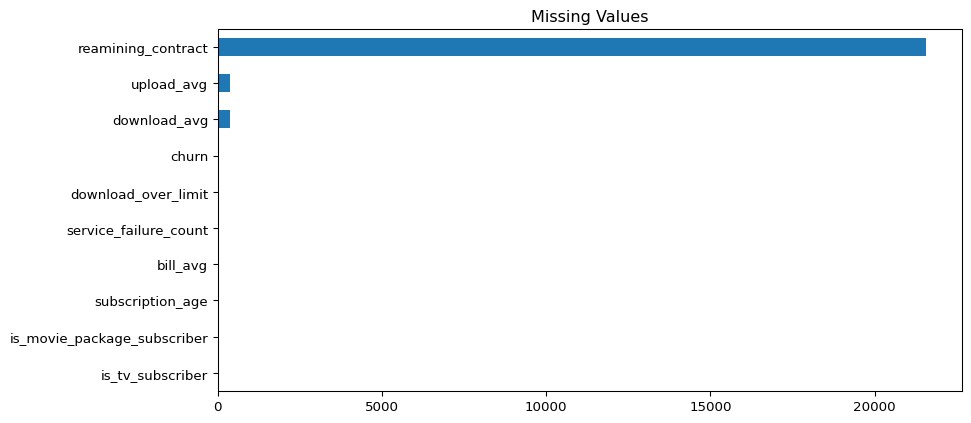

In [7]:
# We can see there are a lot of missing values in the column 'reamining_contract'
# Let's just visualize the number of missing values in each column.
plt.figure(figsize=(10, 5), dpi = 96)
df.isnull().sum().sort_values(ascending=True).plot(kind = 'barh')
plt.title("Missing Values")
plt.show()

In [8]:
# Let's now drop the rows containing missing values.
df.dropna(axis=0, inplace = True)

In [9]:
df.isnull().sum()

is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
reamining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
dtype: int64

In [10]:
df.shape

(50375, 10)

In [11]:
# Now, using RandomForest and permutation_importance, let's check the importance of each column
# in prediction of churn
X_temp = df.copy()

encoder = LabelEncoder()

for column in X_temp.select_dtypes(include = ['object']).columns:
    X_temp[column] = encoder.fit_transform(X_temp[column])

X = X_temp.drop(['churn'], axis = 1)
y = X_temp['churn']

# RandomForest and permutation_importance
clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

result = permutation_importance(clf, X, y, n_jobs=1, random_state=0)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})

feature_importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
4,reamining_contract,0.377810
3,bill_avg,0.085034
2,subscription_age,0.043609
6,download_avg,0.040465
7,upload_avg,0.038817
1,is_movie_package_subscriber,0.030829
0,is_tv_subscriber,0.018255
5,service_failure_count,0.006606
8,download_over_limit,0.000365


In [12]:
df.groupby('is_tv_subscriber')['is_movie_package_subscriber'].value_counts()

is_tv_subscriber  is_movie_package_subscriber
0                 0                               5346
1                 0                              24961
                  1                              20068
Name: is_movie_package_subscriber, dtype: int64

Customers who are not a tv_subscriber, definitely don't subscribe to movie_package.

Conversely, customers who are a tv_subscriber can choose the movie_package service.

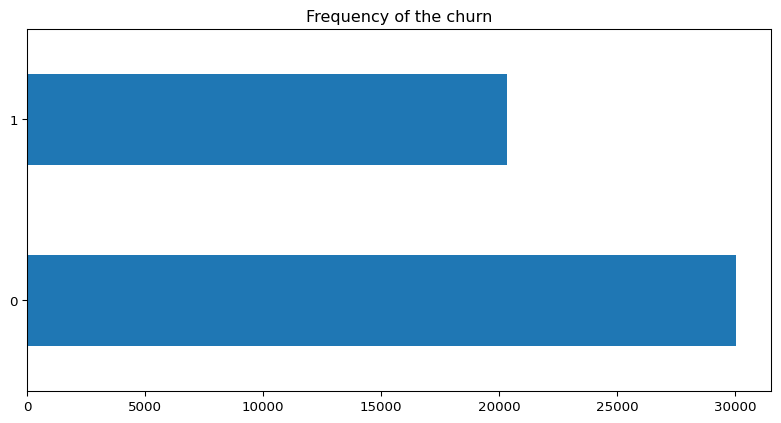

In [13]:
# Here, let's visualize the counts of values in the churn column
plt.figure(figsize=(10, 5), dpi=96)
df['churn'].value_counts().plot(kind = 'barh')
plt.title("Frequency of the churn")
plt.show()

The dataset is imbalanced.
So let's sample them using SMOTE

In [14]:
label_encoder = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

X = df.drop(['churn'], axis=1)
y = df['churn']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(35262, 9) (35262,)
(15113, 9) (15113,)


In [16]:
# Let's resample the train dataset
smote = SMOTE(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [17]:
y_resampled.value_counts()

0    21047
1    21047
Name: churn, dtype: int64

Now, the dataset is balanced.

<h3>Model building</h3>

- First up, using SVM (Support Vector Machine)

In [18]:
# SVM model
svc_model = SVC(random_state = 42)
svc_model.fit(X_resampled, y_resampled)

SVC(random_state=42)

In [19]:
# Accuracy score of the model
print(svc_model.score(X_resampled, y_resampled))

0.84225780396256


In [20]:
# Prediction on test dataset
y_test_pred_svm = svc_model.predict(X_test)

confusion_matrix(y_test, y_test_pred_svm)

array([[7679, 1318],
       [1051, 5065]])

In [21]:
print(classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      8997
           1       0.79      0.83      0.81      6116

    accuracy                           0.84     15113
   macro avg       0.84      0.84      0.84     15113
weighted avg       0.84      0.84      0.84     15113



- Now, with RFC (Random Forest Classifier)

In [22]:
# RFC model
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [23]:
# Accuracy score of the model
print(rf_clf.score(X_resampled, y_resampled))

1.0


Here, we can see that SVM model has an accuracy of 84.22%, while the RFC model has an accuracy of 100%
Hence we can say that RandomForestClassifier is the better one to proceed with over SVM.

In [24]:
# Prediction on the test dataset
y_test_pred_rfc = rf_clf.predict(X_test)
# Confusion matrix on predictions
confusion_matrix(y_test, y_test_pred_rfc)

array([[8837,  160],
       [ 601, 5515]])

In [25]:
# Classification report on predictions
print(classification_report(y_test, y_test_pred_rfc))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      8997
           1       0.97      0.90      0.94      6116

    accuracy                           0.95     15113
   macro avg       0.95      0.94      0.95     15113
weighted avg       0.95      0.95      0.95     15113



In [26]:
# Let's do some HyperParameter Tuning to get the best set of parameters that bring out the best model.
# This step is done to increase the accuracy of the model.
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_clf_2 = RandomForestClassifier(random_state = 42)

grid_search = GridSearchCV(rf_clf_2, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fix the grid search on the DataFrame
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [27]:
# Get the best parameters and the model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best HyperParameters:", best_params)

Best HyperParameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [28]:
# Train the model with the best hyperparameters
best_model.fit(X_resampled, y_resampled)
# Model accuracy
best_model.score(X_resampled, y_resampled)

1.0

In [29]:
# Predictions on the test dataset
y_improved_pred_rfc = best_model.predict(X_test)
# Confusion matrix on predictions
confusion_matrix(y_test, y_improved_pred_rfc)

array([[8842,  155],
       [ 598, 5518]])

In [30]:
# Classification report on predictions
print(classification_report(y_test, y_improved_pred_rfc))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      8997
           1       0.97      0.90      0.94      6116

    accuracy                           0.95     15113
   macro avg       0.95      0.94      0.95     15113
weighted avg       0.95      0.95      0.95     15113



This is the best model we built on this dataset. The model's final accuracy is `95%`.